# Zip Code Digit Classification Dashboard

This dashboard implements and compares various methods for classifying handwritten digits from zip code data, with a particular focus on distinguishing between digits 3, 5, and 8.
This question is from Elements of Statistical Learning
Methods implemented:
1. Standard LDA on the original 256-dimensional space
2. PCA + LDA on the leading 30 principal components
3. Class-specific PCA + LDA - 10 principal components per class
4. Regularized LDA with automatic shrinkage parameter
5. Block-Averaging + LDA - Replace each 3×3 pixel block with its average
6. Multinomial Logistic Regression on block-averaged data (equivalent to R's glmnet)

## 1. Import Libraries and Setup

In [1]:
# Standard Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import os
import sys

# Adjust plot style (using updated style names for newer matplotlib versions)
try:
    plt.style.use('seaborn-whitegrid')  # For older matplotlib versions
except Exception:
    try:
        plt.style.use('seaborn-v0_8-whitegrid')  # For newer matplotlib versions
    except Exception:
        # If neither works, just use the default style
        print("Couldn't apply seaborn-whitegrid style. Using default style.")

sns.set_style("whitegrid")

# Import our custom modules
import zip_utils as utils
import zip_methods as methods
import zip_visualize as viz

# Set random seed for reproducibility
np.random.seed(42)

## 2. Data Loading and Preprocessing

In [2]:
# Attempt to get the data
if utils.check_download_data():
    print("Data ready for analysis.")
else:
    print("Could not get data. Please download the zip.train and zip.test files manually.")

Data ready for analysis.


In [3]:
# Load and filter data
print("Loading data...")
X_train, y_train = utils.load_zip_data('zip.train')
X_test, y_test = utils.load_zip_data('zip.test')

# Filter to only include digits 3, 5, and 8
print("Filtering to digits 3, 5, and 8...")
X_train_filtered, y_train_filtered = utils.filter_digits(X_train, y_train)
X_test_filtered, y_test_filtered = utils.filter_digits(X_test, y_test)

print(f"Training data shape: {X_train_filtered.shape}")
print(f"Test data shape: {X_test_filtered.shape}")

# Count samples per class
classes, counts = np.unique(y_train_filtered, return_counts=True)
print("\nSamples per class in training data:")
for cls, count in zip(classes, counts):
    print(f"Digit {cls}: {count} samples")

Loading data...
Filtering to digits 3, 5, and 8...
Training data shape: (1756, 256)
Test data shape: (492, 256)

Samples per class in training data:
Digit 3: 658 samples
Digit 5: 556 samples
Digit 8: 542 samples


## 3. Data Visualization

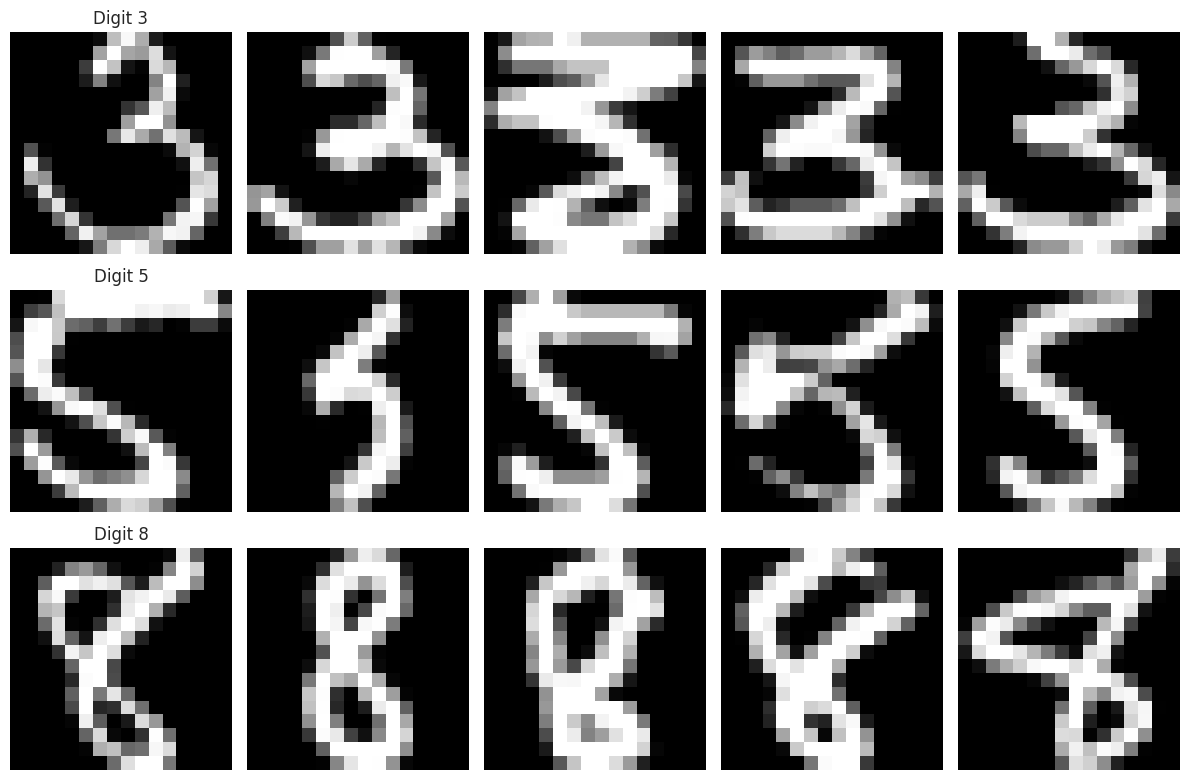

In [4]:
# Visualize sample digits
fig = viz.visualize_digit_samples(X_train_filtered, y_train_filtered)
plt.show()

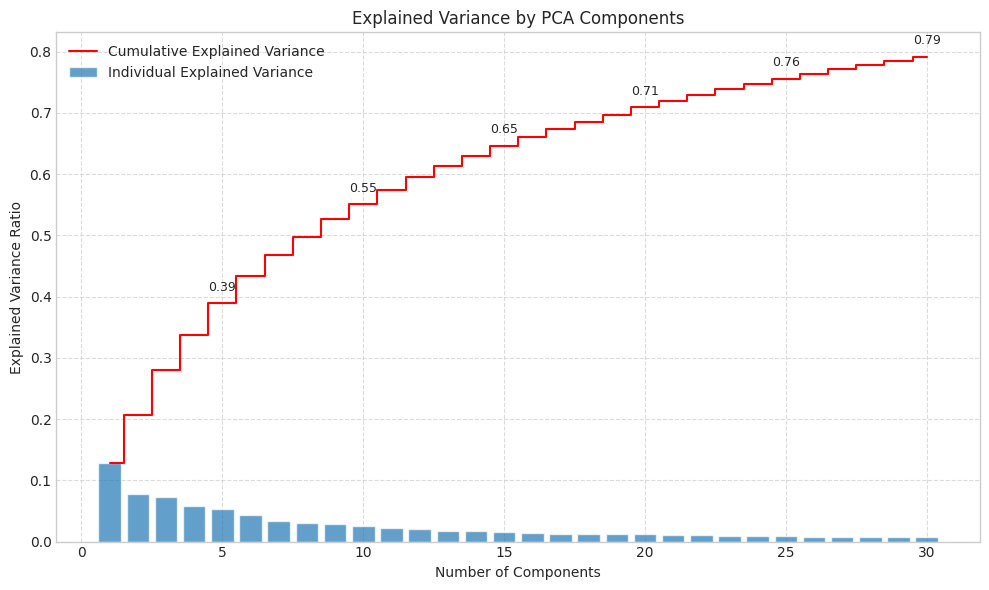

In [5]:
# Visualize PCA explained variance
fig = viz.plot_pca_explained_variance(X_train_filtered)
plt.show()

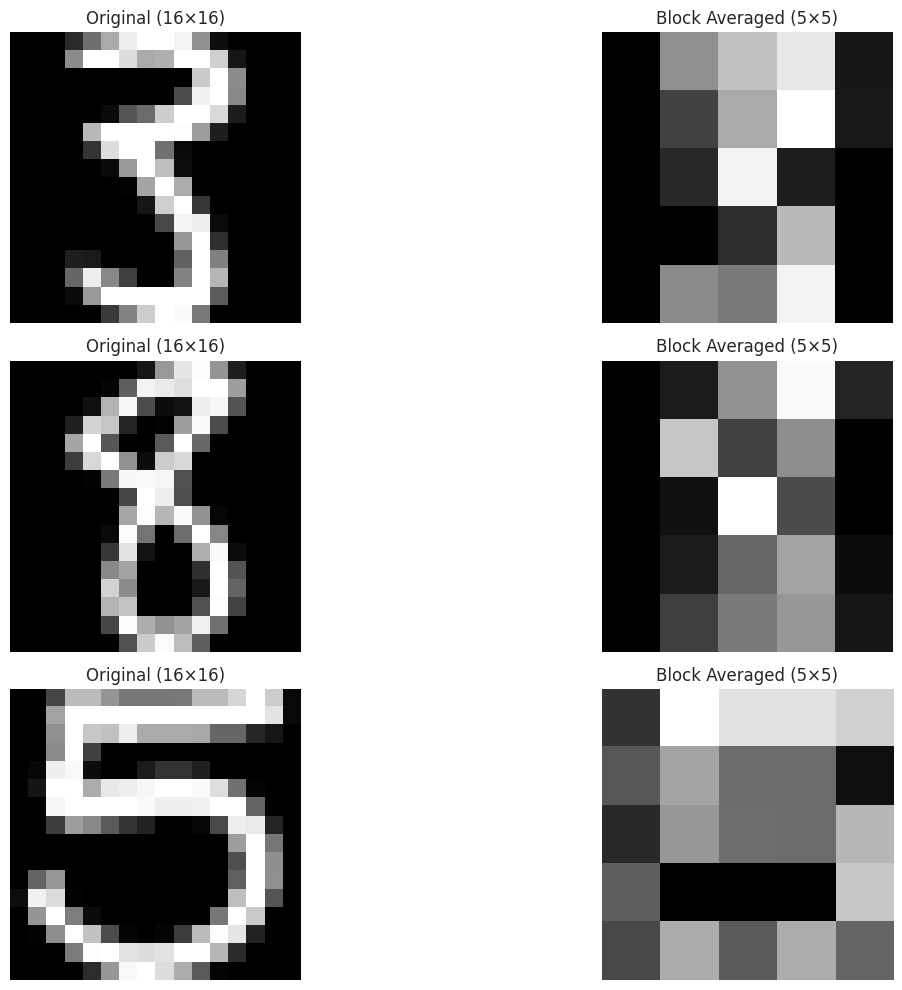

In [6]:
# Visualize block averaging effect
fig = viz.visualize_block_averaging(X_train_filtered, block_size=3)
plt.show()

## 4. Method Implementation and Evaluation

Now we'll implement and evaluate each of the methods described in the introduction.

In [7]:
# Dictionary to store results
results = {}

### 4.1 Standard LDA

In [8]:
print("Running standard LDA...")
results['standard_lda'] = methods.perform_standard_lda(
    X_train_filtered, y_train_filtered,
    X_test_filtered, y_test_filtered
)

print(f"Time: {results['standard_lda']['time']:.2f} seconds")
print(f"Accuracy: {results['standard_lda']['accuracy']:.4f}")
print("\nClassification Report:")
print(results['standard_lda']['report'])

Running standard LDA...
Time: 0.06 seconds
Accuracy: 0.9126

Classification Report:
              precision    recall  f1-score   support

           3       0.90      0.89      0.89       166
           5       0.89      0.91      0.90       160
           8       0.95      0.94      0.95       166

    accuracy                           0.91       492
   macro avg       0.91      0.91      0.91       492
weighted avg       0.91      0.91      0.91       492



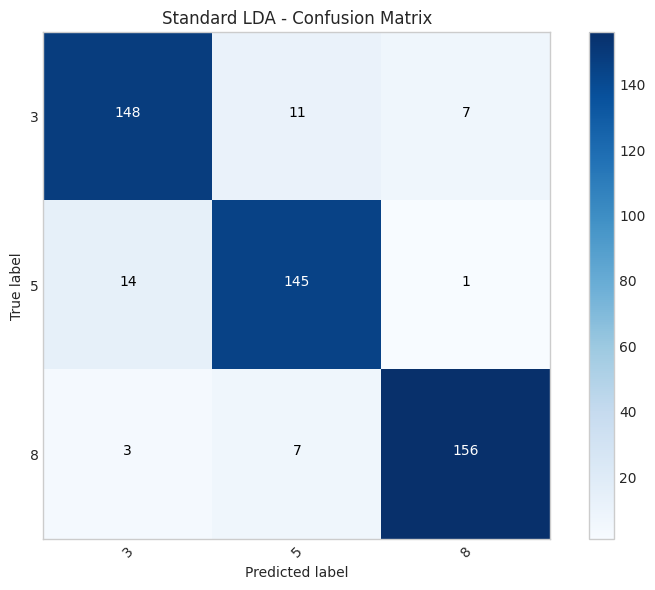

In [9]:
# Plot confusion matrix
fig = viz.plot_confusion_matrix(
    results['standard_lda']['confusion_matrix'],
    classes=np.unique(y_train_filtered),
    title="Standard LDA - Confusion Matrix"
)
plt.show()

### 4.2 PCA + LDA

In [10]:
print("Running PCA (30 components) + LDA...")
results['pca_30_lda'] = methods.perform_pca_lda(
    X_train_filtered, y_train_filtered,
    X_test_filtered, y_test_filtered,
    n_components=30
)

print(f"Time: {results['pca_30_lda']['time']:.2f} seconds")
print(f"Accuracy: {results['pca_30_lda']['accuracy']:.4f}")
print(f"Explained variance ratio: {results['pca_30_lda']['explained_variance_ratio']:.4f}")
print("\nClassification Report:")
print(results['pca_30_lda']['report'])

Running PCA (30 components) + LDA...
Time: 0.40 seconds
Accuracy: 0.9085
Explained variance ratio: 0.7921

Classification Report:
              precision    recall  f1-score   support

           3       0.90      0.89      0.89       166
           5       0.88      0.94      0.91       160
           8       0.96      0.90      0.93       166

    accuracy                           0.91       492
   macro avg       0.91      0.91      0.91       492
weighted avg       0.91      0.91      0.91       492



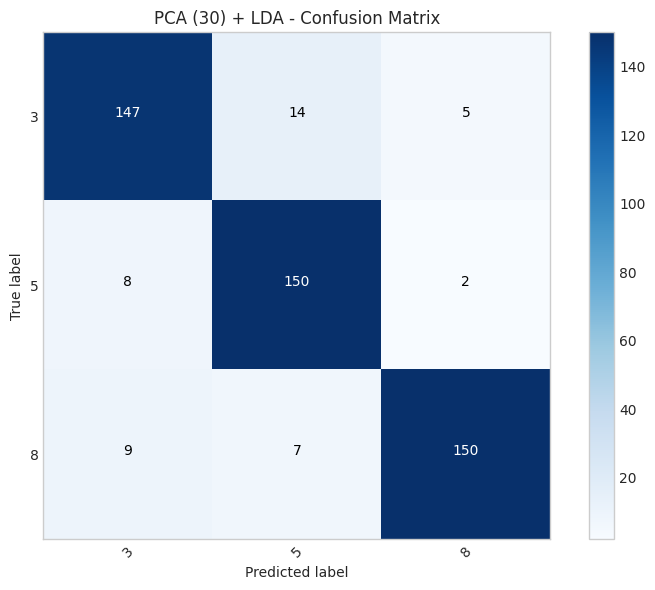

In [11]:
# Plot confusion matrix
fig = viz.plot_confusion_matrix(
    results['pca_30_lda']['confusion_matrix'],
    classes=np.unique(y_train_filtered),
    title="PCA (30) + LDA - Confusion Matrix"
)
plt.show()

### 4.3 Class-Specific PCA + LDA

In [12]:
print("Running Class-Specific PCA (10 components per class) + LDA...")
results['class_pca_lda'] = methods.perform_class_specific_pca_lda(
    X_train_filtered, y_train_filtered,
    X_test_filtered, y_test_filtered,
    n_components_per_class=10
)

print(f"Time: {results['class_pca_lda']['time']:.2f} seconds")
print(f"Accuracy: {results['class_pca_lda']['accuracy']:.4f}")
print("\nClassification Report:")
print(results['class_pca_lda']['report'])

Running Class-Specific PCA (10 components per class) + LDA...
Time: 0.21 seconds
Accuracy: 0.3476

Classification Report:
              precision    recall  f1-score   support

           3       0.35      0.81      0.49       166
           5       0.34      0.21      0.26       160
           8       0.75      0.02      0.04       166

    accuracy                           0.35       492
   macro avg       0.48      0.35      0.26       492
weighted avg       0.48      0.35      0.26       492



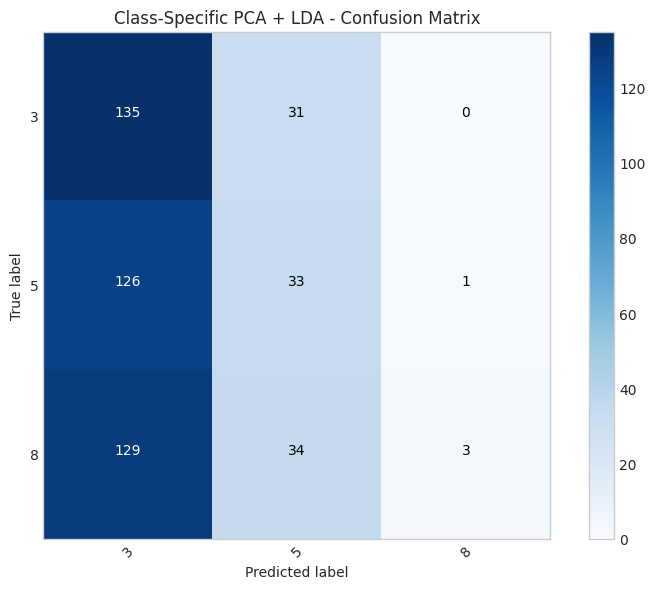

In [13]:
# Plot confusion matrix
fig = viz.plot_confusion_matrix(
    results['class_pca_lda']['confusion_matrix'],
    classes=np.unique(y_train_filtered),
    title="Class-Specific PCA + LDA - Confusion Matrix"
)
plt.show()

### 4.4 Regularized LDA

In [14]:
    print("Running Regularized LDA...")
results['regularized_lda'] = methods.perform_regularized_lda(
    X_train_filtered, y_train_filtered,
    X_test_filtered, y_test_filtered
)

print(f"Time: {results['regularized_lda']['time']:.2f} seconds")
print(f"Accuracy: {results['regularized_lda']['accuracy']:.4f}")
print("\nClassification Report:")
print(results['regularized_lda']['report'])

Running Regularized LDA...
Time: 0.12 seconds
Accuracy: 0.9207

Classification Report:
              precision    recall  f1-score   support

           3       0.91      0.90      0.91       166
           5       0.90      0.93      0.91       160
           8       0.95      0.94      0.95       166

    accuracy                           0.92       492
   macro avg       0.92      0.92      0.92       492
weighted avg       0.92      0.92      0.92       492



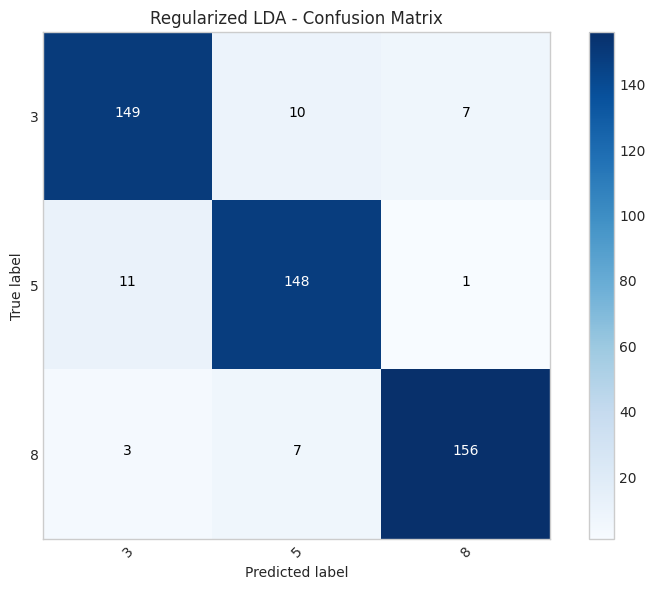

In [15]:
# Plot confusion matrix
fig = viz.plot_confusion_matrix(
    results['regularized_lda']['confusion_matrix'],
    classes=np.unique(y_train_filtered),
    title="Regularized LDA - Confusion Matrix"
)
plt.show()

### 4.5 Block Averaging + LDA

In [16]:
print("Running Block Averaging (3×3) + LDA...")
results['block_avg_lda'] = methods.perform_lda_with_block_averaging(
    X_train_filtered, y_train_filtered,
    X_test_filtered, y_test_filtered,
    block_size=3
)

print(f"Time: {results['block_avg_lda']['time']:.2f} seconds")
print(f"Accuracy: {results['block_avg_lda']['accuracy']:.4f}")
print(f"Reduced feature count: {results['block_avg_lda']['processed_features']}")
print("\nClassification Report:")
print(results['block_avg_lda']['report'])

Running Block Averaging (3×3) + LDA...
Time: 0.24 seconds
Accuracy: 0.8882
Reduced feature count: 25

Classification Report:
              precision    recall  f1-score   support

           3       0.89      0.86      0.87       166
           5       0.85      0.92      0.88       160
           8       0.93      0.89      0.91       166

    accuracy                           0.89       492
   macro avg       0.89      0.89      0.89       492
weighted avg       0.89      0.89      0.89       492



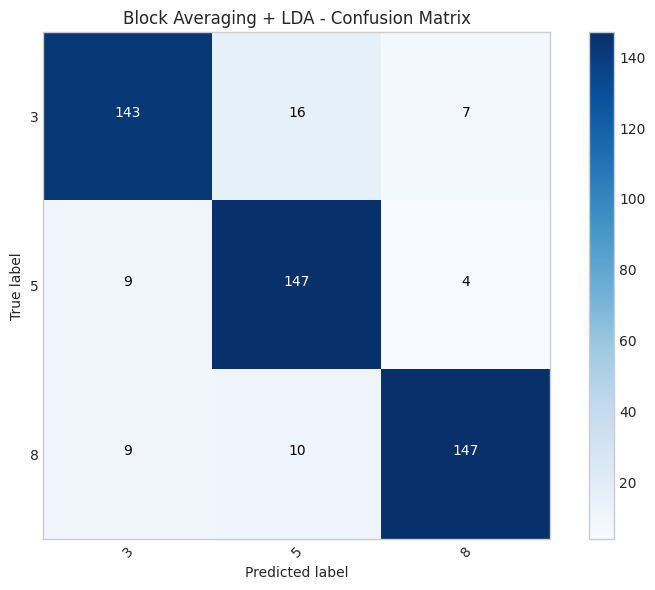

In [17]:
# Plot confusion matrix
fig = viz.plot_confusion_matrix(
    results['block_avg_lda']['confusion_matrix'],
    classes=np.unique(y_train_filtered),
    title="Block Averaging + LDA - Confusion Matrix"
)
plt.show()

### 4.6 Logistic Regression on Block-Averaged Data

In [18]:
# Visualize regularization path
fig = viz.visualize_regularization_path(
    X_train_filtered, y_train_filtered,
    block_size=3,
    n_alphas=10
)
plt.show()

/home/blueaz/Python/ESL/Hmk2/JupyterZip/zip_visualize.py:426: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


In [19]:
print("Finding optimal regularization parameter for logistic regression...")
logistic_results = methods.find_best_logistic_model(
    X_train_filtered, y_train_filtered,
    X_test_filtered, y_test_filtered,
    block_size=3,
    C_values=[0.1, 0.01, 0.001]
)

best_C = logistic_results['best_C']
print(f"Best C value: {best_C}")

# Add best model to results
results['logistic_regression'] = logistic_results['best_result']

print(f"Time: {results['logistic_regression']['time']:.2f} seconds")
print(f"Accuracy: {results['logistic_regression']['accuracy']:.4f}")
print(f"Reduced feature count: {results['logistic_regression']['processed_features']}")

# Find non-zero coefficients in the logistic regression model
coefs = results['logistic_regression']['model_coefficients']
non_zero_coefs = np.sum(np.abs(coefs) > 1e-10)
print(f"Number of non-zero coefficients: {non_zero_coefs} out of {coefs.size}")

print("\nClassification Report:")
print(results['logistic_regression']['report'])

Finding optimal regularization parameter for logistic regression...
Best C value: 0.1
Time: 0.26 seconds
Accuracy: 0.8841
Reduced feature count: 25
Number of non-zero coefficients: 30 out of 75

Classification Report:
              precision    recall  f1-score   support

           3       0.91      0.84      0.87       166
           5       0.82      0.91      0.86       160
           8       0.93      0.91      0.92       166

    accuracy                           0.88       492
   macro avg       0.89      0.88      0.88       492
weighted avg       0.89      0.88      0.88       492



/home/blueaz/Python/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/blueaz/Python/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/blueaz/Python/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


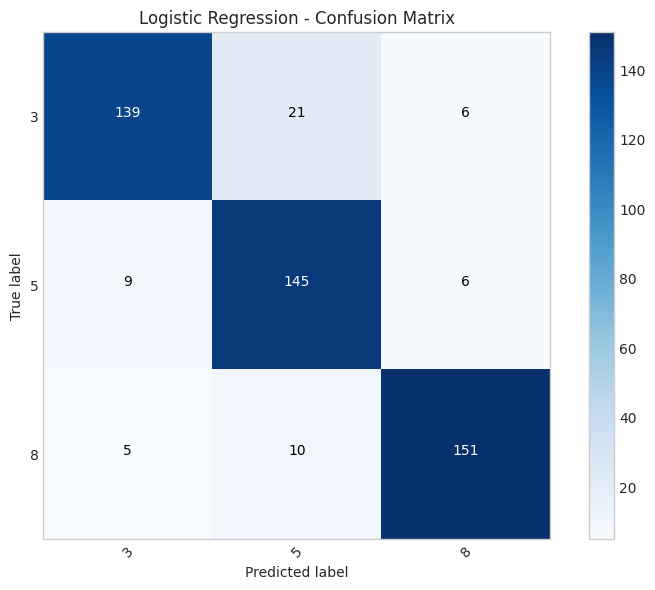

In [20]:
# Plot confusion matrix
fig = viz.plot_confusion_matrix(
    results['logistic_regression']['confusion_matrix'],
    classes=np.unique(y_train_filtered),
    title="Logistic Regression - Confusion Matrix"
)
plt.show()

## Methods Implemented - Complete!

We've now implemented all six methods for classifying the handwritten digits. The results are stored in the `results` dictionary. Run the second notebook (`zip_dash_part2.ipynb`) to analyze the results and draw conclusions.